You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.

In [4]:
import os
# either provide a path to local NeMo repository with NeMo already installed or git clone
BRANCH = 'chooper-dl'

# option #1: local path to NeMo repo with NeMo already installed
NEMO_DIR_PATH = "NeMo"

# option #2: download NeMo repo
if 'google.colab' in str(get_ipython()) or not os.path.exists(NEMO_DIR_PATH):
  ! git clone -b $BRANCH https://github.com/chooper1/NeMo
  % cd NeMo
  ! python -m pip install git+https://github.com/chooper1/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

In [10]:
import json
import os
import wget
import numpy as np

! pip install cmake
! pip install https://github.com/DavidDiazGuerra/gpuRIR/zipball/master

  Using cached https://github.com/DavidDiazGuerra/gpuRIR/zipball/master


# Introduction

This tutorial shows how to use the speech data simulator to generate synthetic multispeaker audio sessions that can be used to train or evaluate models for multispeaker ASR or speaker diarization. This tool aims to address the lack of labelled multispeaker training data and to help models deal with overlapping speech.

# Step 1: Download Required Datasets

The LibriSpeech dataset and corresponding word alignments are required for generating synthetic multispeaker audio sessions. For simplicity, only the dev-clean dataset is used for generating synthetic sessions.

In [125]:
!mkdir LibriSpeech
!python NeMo/scripts/dataset_processing/get_librispeech_data.py \
  --data_root LibriSpeech \
  --data_sets dev_clean

100%|████████████████████████████████████████| 322M/322M [00:18<00:00, 18.2MB/s]
100%|███████████████████████████████████████████| 97/97 [00:18<00:00,  5.18it/s]


The LibriSpeech forced word alignments are from the following repository: https://github.com/CorentinJ/librispeech-alignments

The google drive link is: https://drive.google.com/file/d/1WYfgr31T-PPwMcxuAq09XZfHQO5Mw8fE/view?usp=sharing

In [127]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1WYfgr31T-PPwMcxuAq09XZfHQO5Mw8fE
!unzip LibriSpeech-Alignments.zip -d LibriSpeech_Alignments
!rm LibriSpeech-Alignments.zip

Downloading...
From: https://drive.google.com/uc?id=1WYfgr31T-PPwMcxuAq09XZfHQO5Mw8fE
To: /home/chooper/projects/chooper_dl/NeMo/tutorials/tools/LibriSpeech-Alignments.zip
100%|██████████████████████████████████████| 71.7M/71.7M [00:15<00:00, 4.56MB/s]
Archive:  LibriSpeech-Alignments.zip
   creating: LibriSpeech_Alignments/LibriSpeech/
   creating: LibriSpeech_Alignments/LibriSpeech/dev-clean/
   creating: LibriSpeech_Alignments/LibriSpeech/dev-clean/1272/
   creating: LibriSpeech_Alignments/LibriSpeech/dev-clean/1272/128104/
  inflating: LibriSpeech_Alignments/LibriSpeech/dev-clean/1272/128104/1272-128104.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/dev-clean/1272/135031/
  inflating: LibriSpeech_Alignments/LibriSpeech/dev-clean/1272/135031/1272-135031.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/dev-clean/1272/141231/
  inflating: LibriSpeech_Alignments/LibriSpeech/dev-clean/1272/141231/1272-141231.alignment.txt  
   creating: LibriSpeech_Alignm

  inflating: LibriSpeech_Alignments/LibriSpeech/test-other/4294/14317/4294-14317.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/test-other/4294/32859/
  inflating: LibriSpeech_Alignments/LibriSpeech/test-other/4294/32859/4294-32859.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/test-other/4294/35475/
  inflating: LibriSpeech_Alignments/LibriSpeech/test-other/4294/35475/4294-35475.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/test-other/4294/9934/
  inflating: LibriSpeech_Alignments/LibriSpeech/test-other/4294/9934/4294-9934.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/test-other/4350/
   creating: LibriSpeech_Alignments/LibriSpeech/test-other/4350/10919/
  inflating: LibriSpeech_Alignments/LibriSpeech/test-other/4350/10919/4350-10919.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/test-other/4350/9170/
  inflating: LibriSpeech_Alignments/LibriSpeech/test-other/4350/9170/4350-9170.alignment.txt  
   c

  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/3857/182317/3857-182317.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/3879/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/3879/173592/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/3879/173592/3879-173592.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/3879/174923/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/3879/174923/3879-174923.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/39/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/3947/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/3947/13260/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/3947/13260/3947-13260.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/3947/13262/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/3947/132

  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/7800/283492/7800-283492.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/7800/283493/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/7800/283493/7800-283493.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/7859/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/7859/102518/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/7859/102518/7859-102518.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/7859/102519/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/7859/102519/7859-102519.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/7859/102521/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/7859/102521/7859-102521.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-100/78/368/
  inflating: LibriSpeech_Align

  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/1460/138290/1460-138290.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/1463/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/1463/134463/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/1463/134463/1463-134463.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/1463/134465/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/1463/134465/1463-134465.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/1472/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/1472/139797/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/1472/139797/1472-139797.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/1472/142848/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/1472/142848/1472-142848.alignment.txt  
   creating: LibriSpeech_Alignme

  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/2269/88761/2269-88761.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/227/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/2272/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/2272/150674/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/2272/150674/2272-150674.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/2272/152262/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/2272/152262/2272-152262.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/2272/152264/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/2272/152264/2272-152264.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/2272/152265/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/2272/152265/2272-152265.alignment.txt  
   creating: LibriSpeech_Alignments

  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/3274/167022/3274-167022.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/3274/167023/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/3274/167023/3274-167023.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/3289/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/3289/171107/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/3289/171107/3289-171107.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/3289/171108/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/3289/171108/3289-171108.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/3289/171109/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/3289/171109/3289-171109.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/329/
   creating: LibriSpeech_Alignmen

  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/4331/88349/4331-88349.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/4335/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/4335/15081/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/4335/15081/4335-15081.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/4335/15082/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/4335/15082/4335-15082.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/434/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/434/132644/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/434/132644/434-132644.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/434/132645/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/434/132645/434-132645.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech

  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/5588/68188/5588-68188.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/5588/68192/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/5588/68192/5588-68192.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/559/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/559/126296/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/559/126296/559-126296.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/559/289453/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/559/289453/559-289453.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/55/121068/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/55/121068/55-121068.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/55/121069/
  inflating: LibriSpeech_Alignments/LibriSpee

  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/6510/62516/6510-62516.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/6510/62558/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/6510/62558/6510-62558.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/6518/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/6518/66464/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/6518/66464/6518-66464.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/6518/66465/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/6518/66465/6518-66465.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/6518/66470/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/6518/66470/6518-66470.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/6519/
   creating: LibriSpeech_Alignments/LibriSpeec

   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/7594/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/7594/101832/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/7594/101832/7594-101832.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/7594/81881/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/7594/81881/7594-81881.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/7594/91192/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/7594/91192/7594-91192.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/764/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/7647/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/7647/102250/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/7647/102250/7647-102250.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/764/13227

  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/8575/290349/8575-290349.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/8575/290350/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/8575/290350/8575-290350.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/8575/290351/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/8575/290351/8575-290351.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/8591/
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/8591/284444/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/8591/284444/8591-284444.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/8591/284445/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/8591/284445/8591-284445.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-clean-360/8592/
   creating: LibriSpeech_Alignme

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/1421/8522/1421-8522.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/1421/8534/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/1421/8534/1421-8534.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/1421/8539/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/1421/8539/1421-8539.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/1430/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/1430/1061/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/1430/1061/1430-1061.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/1430/139231/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/1430/139231/1430-139231.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/1444/
   creating: LibriSpeech_Alignments/LibriSpeech/train-

   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2104/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2104/75220/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2104/75220/2104-75220.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2104/78240/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2104/78240/2104-78240.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2104/78253/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2104/78253/2104-78253.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2122/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2122/149350/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2122/149350/2122-149350.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2133/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2133/2145/


  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2997/163246/2997-163246.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2998/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2998/160954/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2998/160954/2998-160954.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2998/160955/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/2998/160955/2998-160955.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/29/123027/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/29/123027/29-123027.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/29/123032/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/29/123032/29-123032.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/29/126858/
  inflating: LibriSpeech_Alignments/Lib

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/3779/691/3779-691.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/377/129290/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/377/129290/377-129290.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/377/129292/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/377/129292/377-129292.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/3780/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/3780/177782/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/3780/177782/3780-177782.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/3780/177784/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/3780/177784/3780-177784.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/3780/177788/
  inflating: LibriSpeech_Alignments/L

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/4463/707/4463-707.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/4474/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/4474/14185/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/4474/14185/4474-14185.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/4474/14186/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/4474/14186/4474-14186.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/448/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/4480/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/4480/44312/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/4480/44312/4480-44312.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/4480/8371/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/4480/8371/4480-8371.

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/5181/2489/5181-2489.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/5181/2490/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/5181/2490/5181-2490.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/5183/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/5183/116605/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/5183/116605/5183-116605.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/5183/29124/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/5183/29124/5183-29124.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/5183/66175/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/5183/66175/5183-66175.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/5183/68763/
  inflating: LibriSpeech_Alignments/LibriS

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/1335-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/1336-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/1337-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/1341-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/1342-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/1343-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/1347-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/1348-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/1349-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/12902

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/2162-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/2167-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/217-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/218-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/2182-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/2194-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/2196-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/22-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/2201-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/22

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/3347-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/335-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/3357-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/336-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/3361-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/3368-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/337-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/3370-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/3374-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/3

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/47-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/470-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/4719-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/472-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/4731-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/4733-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/4734-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/474-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/4744-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/475

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/6081-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/6082-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/6098-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/6099-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/61-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/6104-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/6115-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/6119-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/612-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/6

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/7398-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/7402-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/7416-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/742-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/7434-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/7437-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/7445-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/7447-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/7460-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/8643-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/8677-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/868-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/8684-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/8687-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/8699-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/87-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/8705-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/8713-129024.alignment.txt  
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/551/129024/8

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6009/57643/6009-57643.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6009/57646/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6009/57646/6009-57646.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6010/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6010/56787/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6010/56787/6010-56787.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6010/56788/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6010/56788/6010-56788.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6025/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6025/56405/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6025/56405/6025-56405.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeec

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6668/34648/6668-34648.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6670/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6670/112764/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6670/112764/6670-112764.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6670/296083/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6670/296083/6670-296083.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6670/84209/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6670/84209/6670-84209.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6674/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6674/71396/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/6674/71396/6674-71396.alignment.txt  
   creating: LibriSpeech_Alignments/Libr

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7246/63505/7246-63505.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7246/86779/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7246/86779/7246-86779.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7250/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7250/86746/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7250/86746/7250-86746.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7255/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7255/281336/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7255/281336/7255-281336.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7255/281345/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7255/281345/7255-281345.alignment.txt  
   creating: LibriSpeech_Alignments/Libr

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/792/127527/792-127527.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/792/127528/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/792/127528/792-127528.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7942/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7942/283384/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7942/283384/7942-283384.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7942/283400/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7942/283400/7942-283400.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7942/292240/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7942/292240/7942-292240.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/7946/
   creating: LibriSpeech_Alignments/L

  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/8778/246984/8778-246984.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/8799/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/8799/270794/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/8799/270794/8799-270794.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/8799/291938/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/8799/291938/8799-291938.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/8803/
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/8803/296082/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/8803/296082/8803-296082.alignment.txt  
   creating: LibriSpeech_Alignments/LibriSpeech/train-other-500/8803/296085/
  inflating: LibriSpeech_Alignments/LibriSpeech/train-other-500/8803/296085/8803-296085.alignment.txt  
   creating: LibriSpeech_Alignme

# Step 2: Produce Manifest File with Forced Alignments

The LibriSpeech manifest file and LibriSpeech forced alignments will now be merged into one manifest file for ease of use when generating synthetic data.

In [128]:
!python NeMo/scripts/speaker_tasks/create_alignment_manifest.py \
  --input_manifest_filepath LibriSpeech/dev_clean.json \
  --base_alignment_path LibriSpeech_Alignments \
  --dataset dev-clean \
  --output_path dev-clean-align.json

[NeMo W 2022-07-12 20:00:03 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.


# Data Simulator Overview

The simulator creates a speech session using utterances from a desired number of speakers. The simulator first selects the LibriSpeech speaker IDs that will be used for the current session, and sets speaker dominance values for each speaker to determine how often each speaker will talk in the session. The session is then constructed by iterating through the following steps:

* The next speaker is selected (which could be the same speaker again with some probability, and which accounts for the speaker dominance values).
* The sentence length is determined using a probability distribution, and an utterance of the desired length is then constructed by concatenating together (or truncating) LibriSpeech sentences corresponding to the desired speaker. Individual word alignments are used to truncate the last LibriSpeech sentence such that the entire utterance has the desired length.
* Next, either the current utterance is overlapped with a previous utterance or silence is introduced before inserting the current utterance. 

The simulator includes a multi-microphone far-field mode that incorporates synthetic room impulse response generation in order to simulate multi-microphone multispeaker sessions. When using RIR generation, the RIR is computed once per batch of sessions, and then each constructed utterance is convolved with the RIR in order to get the sound recorded by each microphone before adding the utterance to the audio session. In this tutorial, only close-talk sessions will be generated.

The simulator also has a speaker enforcement mode which ensures that the correct number of speakers appear in each session, since it is possible that fewer than the desired number may be present since speaker turns are probabilistic. In speaker enforcement mode, the length of the session or speaker probabilites may be adjusted to ensure all speakers are included before the session finishes.

# Parameters

In [129]:
from omegaconf import OmegaConf
conf = OmegaConf.load('NeMo/tools/speech_data_simulator/conf/data_simulator.yaml')
print(OmegaConf.to_yaml(conf))

data_simulator:
  manifest_path: null
  enforce_num_speakers: false
  sr: 16000
  random_seed: 42
  session_config:
    num_speakers: 4
    num_sessions: 5
    session_length: 600
  session_params:
    sentence_length_params:
    - 0.4
    - 0.05
    dominance_var: 0.11
    min_dominance: 0.05
    turn_prob: 0.875
    mean_overlap: 0.19
    mean_silence: 0.15
    overlap_prob: 0.5
    window_type: hamming
    window_size: 0.1
    normalization: equal
    normalization_var: 0.1
  outputs:
    output_dir: null
    output_filename: diarization_session
    overwrite_output: true
    output_files: rjctl
  segment_manifest:
    window: 0.5
    shift: 0.25
    step_count: 50
    deci: 3
  rir_generation:
    use_rir: false



# Step 3: Generate Simulated Audio Session

A single 4-speaker session of 5 minutes is generated as an example.

In [130]:
!python NeMo/tools/speech_data_simulator/multispeaker_simulator.py \
  --config-path='conf' --config-name='data_simulator.yaml' \
  data_simulator.random_seed=42 \
  data_simulator.manifest_path="dev-clean-align.json" \
  data_simulator.outputs.output_dir="test_closetalk" \
  data_simulator.session_config.num_sessions=1 \
  data_simulator.session_config.session_length=60 

[NeMo W 2022-07-12 20:00:52 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
Generating Diarization Sessions
Generating Session Number 0


# Step 4: Listen to and Visualize Session

Listen to the audio and visualize the corresponding speaker timestamps (recorded in a RTTM file for each session)

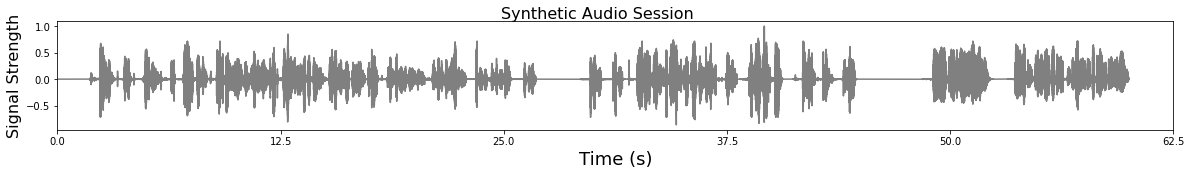

In [131]:
import os
import wget
import IPython
import matplotlib.pyplot as plt
import numpy as np
import librosa
from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels, labels_to_pyannote_object


ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'test_closetalk')
audio = os.path.join(data_dir,'diarization_session_0.wav')
rttm = os.path.join(data_dir,'diarization_session_0.rttm')

sr = 16000
signal, sr = librosa.load(audio,sr=sr) 

fig,ax = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(np.arange(len(signal)),signal,'gray')
fig.suptitle('Synthetic Audio Session', fontsize=16)
plt.xlabel('Time (s)', fontsize=18)
ax.margins(x=0)
plt.ylabel('Signal Strength', fontsize=16);
a,_ = plt.xticks();plt.xticks(a,a/sr);

IPython.display.Audio(audio)

The visualization is useful for seeing both the distribution of utterance lengths, the differing speaker dominance values, and the amount of overlap in the session.

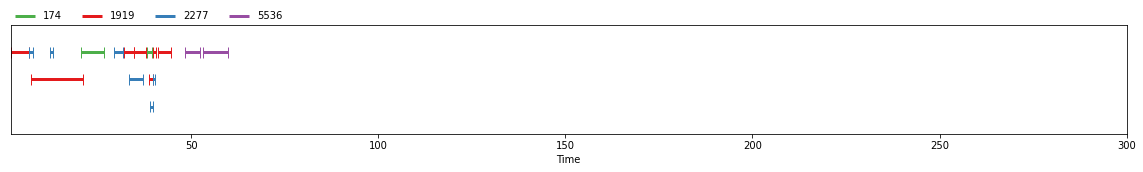

In [132]:
#display speaker labels for reference
labels = rttm_to_labels(rttm)
reference = labels_to_pyannote_object(labels)
reference

# Files Produced

The following files are produced by the simulator:

* wav files (one per audio session) - the output audio sessions
* rttm files (one per audio session) - the speaker timestamps for the corresponding audio session (used for diarization training)
* json files (one per audio session) - the output manifest file for the corresponding audio session (containing text transcriptions, utterance durations, full paths to audio files, words, and word alignments)
* ctm files (one per audio session) - contains word-by-word alignments, speaker ID, and word
* txt files (one per audio session) - contains the full text transcription for a given session
* list files (one per file type per batch of sessions) - a list of generated files of the given type (wav, rttm, json, ctm, or txt), used primarily for manifest creation


In [133]:
!ls test_closetalk

diarization_session_0.ctm   diarization_session_0.wav  synthetic_txt.list
diarization_session_0.json  synthetic_ctm.list	       synthetic_wav.list
diarization_session_0.rttm  synthetic_json.list
diarization_session_0.txt   synthetic_rttm.list
